In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [15]:
# Load the Adult Income dataset
data = fetch_openml(name='adult', version=2)

# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Perform one-hot encoding for categorical features
df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

df.head()


/Users/Kerryn/fairness/venv_fairness_310/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25.0,226802.0,7.0,0.0,0.0,40.0,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,38.0,89814.0,9.0,0.0,0.0,50.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,28.0,336951.0,12.0,0.0,0.0,40.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,Fal

In [16]:
# Define the target variable (income) and the protected attribute (gender)
X = df
y = (data.target == '>50K').astype(int)  # Convert income to binary (1 if >50K, 0 otherwise)
protected_attribute = df['sex_Female'].astype(int)  # Use one of the gender columns for the protected attribute

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X, y, protected_attribute, test_size=0.2, random_state=42
)

In [17]:
# Define a parameter grid for grid search
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Create a logistic regression model
logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000)

# Set up cross-validation (e.g., 10-fold cross-validation)
cross_val = 10

# Perform grid search
grid_search = GridSearchCV(logistic_regression, param_grid, cv=cross_val, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [19]:



# Initialize lists to store accuracy and DI scores
accuracy_scores = []
di_scores = []

for i, cv_result in enumerate(grid_search.cv_results_['params']):
    # Train a logistic regression model with the specific parameters
    model = LogisticRegression(solver='liblinear', max_iter=1000, **cv_result)
    model.fit(X_train, y_train)

    # Make predictions for both protected and non-protected groups
    predictions_protected = model.predict(X_test[gender_test == 1])
    predictions_non_protected = model.predict(X_test[gender_test == 0])

    # Calculate accuracy for the current model
    accuracy = accuracy_score(y_test, model.predict(X_test))
    accuracy_scores.append(accuracy)

    # Calculate DI score for the current model
    p_protected = np.mean(predictions_protected)
    p_non_protected = np.mean(predictions_non_protected)
    di_score = p_protected / p_non_protected
    di_scores.append(di_score)

# Print accuracy and DI scores for each model
for i in range(len(accuracy_scores)):
    print(f"Model {i + 1}:")
    print(f"Accuracy: {accuracy_scores[i]:.4f}")
    print(f"Disparate Impact (DI): {di_scores[i]:.4f}")

Model 1:
Accuracy: 0.8552
Disparate Impact (DI): 0.2790
Model 2:
Accuracy: 0.8039
Disparate Impact (DI): 0.5392
Model 3:
Accuracy: 0.8572
Disparate Impact (DI): 0.2895
Model 4:
Accuracy: 0.8039
Disparate Impact (DI): 0.5392
Model 5:
Accuracy: 0.8569
Disparate Impact (DI): 0.2858
Model 6:
Accuracy: 0.8039
Disparate Impact (DI): 0.5392


In [20]:
# Initialize a dictionary to store results
results_dict = {
    "models": [],
    "accuracy_scores": [],
    "di_scores": []
}

# Iterate through the cross-validation results
for i, cv_result in enumerate(grid_search.cv_results_['params']):
    # Train a logistic regression model with the specific parameters
    model = LogisticRegression(solver='liblinear', max_iter=1000, **cv_result)
    model.fit(X_train, y_train)

    # Make predictions for both protected and non-protected groups
    predictions_protected = model.predict(X_test[gender_test == 1])
    predictions_non_protected = model.predict(X_test[gender_test == 0])

    # Calculate accuracy for the current model
    accuracy = accuracy_score(y_test, model.predict(X_test))

    # Calculate DI score for the current model
    p_protected = np.mean(predictions_protected)
    p_non_protected = np.mean(predictions_non_protected)
    di_score = p_protected / p_non_protected

    # Save model, accuracy, and DI scores in the dictionary
    results_dict["models"].append(model)
    results_dict["accuracy_scores"].append(accuracy)
    results_dict["di_scores"].append(di_score)

# Print accuracy and DI scores for each model
for i in range(len(results_dict["accuracy_scores"])):
    print(f"Model {i + 1}:")
    print(f"Accuracy: {results_dict['accuracy_scores'][i]:.4f}")
    print(f"Disparate Impact (DI): {results_dict['di_scores'][i]:.4f}")

Model 1:
Accuracy: 0.8548
Disparate Impact (DI): 0.2782
Model 2:
Accuracy: 0.8039
Disparate Impact (DI): 0.5392
Model 3:
Accuracy: 0.8573
Disparate Impact (DI): 0.2904
Model 4:
Accuracy: 0.8039
Disparate Impact (DI): 0.5392
Model 5:
Accuracy: 0.8569
Disparate Impact (DI): 0.2862
Model 6:
Accuracy: 0.8039
Disparate Impact (DI): 0.5392


In [21]:
results_dict

{'models': [LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear'),
  LogisticRegression(C=0.1, max_iter=1000, solver='liblinear'),
  LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear'),
  LogisticRegression(C=1, max_iter=1000, solver='liblinear'),
  LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='liblinear'),
  LogisticRegression(C=10, max_iter=1000, solver='liblinear')],
 'accuracy_scores': [0.8548469648889344,
  0.8038693827413246,
  0.8573037158358071,
  0.8038693827413246,
  0.8568942573446617,
  0.8038693827413246],
 'di_scores': [0.27817465939012903,
  0.5391753932121068,
  0.29035453529399685,
  0.5391753932121068,
  0.2861879943022999,
  0.5391753932121068]}

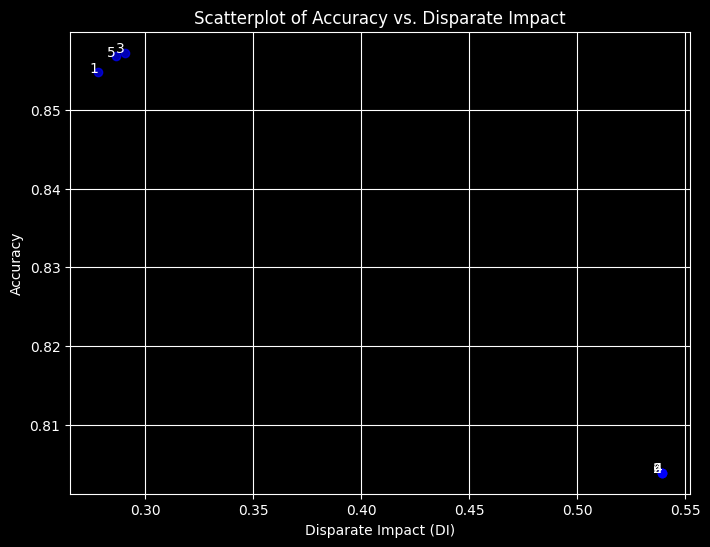

In [22]:


# Access accuracy and DI scores from the results_dict
accuracy_scores = results_dict["accuracy_scores"]
di_scores = results_dict["di_scores"]

# Create a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(di_scores, accuracy_scores, marker='o', c='blue', alpha=0.7)
plt.title("Scatterplot of Accuracy vs. Disparate Impact")
plt.xlabel("Disparate Impact (DI)")
plt.ylabel("Accuracy")
plt.grid(True)

# Add labels for each point (model)
for i, txt in enumerate(range(1, len(di_scores) + 1)):
    plt.annotate(txt, (di_scores[i], accuracy_scores[i]), fontsize=10, ha='right')

# Show the scatterplot
plt.show()
